In [1]:
import io, keras, string, itertools, random, datetime, numpy as np, matplotlib.pyplot as plt, tensorflow as tf
from string import punctuation
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
from keras.callbacks import TensorBoard, EarlyStopping
from keras.models import Sequential, Model
from keras.utils import to_categorical
from keras.initializers import glorot_uniform, random_uniform
from keras.layers import Activation
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import Adam
from keras.layers import Embedding, Conv1D, Flatten, Dense, Dropout, MaxPool1D, LSTM, \
Bidirectional, TimeDistributed, Dropout, GlobalMaxPooling1D, Input, concatenate, Reshape
from keras import regularizers
from keras.utils import plot_model
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [2]:
# Define custom functions
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    '''
    Description: Prints and plots the confusion matrix.	Normalization can be applied by setting `normalize=True`

    Args:
    - cm: Confusion Matrix
    - classes: Names of classes
    - normalize: Whether to or to not normal values in Confusion Matrix
    - cmap: Plot color
    '''

    # Check if normalize is true or false
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    # Format axis and plot Confusion Matrix
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    return data

def get_labels(seq):
    '''
    Description: Creates a sequence of labels based on the input sequence

    Args:
    - seq: Input sequence
    
    Returns:
        Sequence labels
    '''
    
    labels_seq = []
    seq = seq.split()
    for i in range(len(seq)):
        if ',' in seq[i]:
            labels_seq.append('<comma>')
        elif '.' in seq[i]:
            labels_seq.append('<period>')
        elif '?' in seq[i]:
            labels_seq.append('<question>')
        elif '!' in seq[i]:
            labels_seq.append('<exclaim>')
        else:
            labels_seq.append('<na>')
    return labels_seq

In [3]:
# Set model parameters
name_1 = 'ted-glove-lstm'
name_2 = 'ted-glove-cnn-lstm'
model_name = name_1
max_seq_len = 128
drop_prob = 0.2
no_filters_1 = 32
no_filters_2 = 64
no_filters_3 = 32
filter_sizes = [32,32,32]
kernel_weight = glorot_uniform(seed=50)
bias = random_uniform(seed=50)
kernel_reg = regularizers.l2(l=0.0001)
kernels = [3,5,7]
kernel_1 = 3
kernel_2 = 5
kernel_3 = 7
lstm_hidden = 100
embed_dim = 300
adam_lr = 0.001
batch_size = 128
epochs = 20
valid_split = 0.3

In [4]:
# Set misc parameters
current = datetime.datetime.now()
date = current.strftime('%b-%d')
tensor_b = TensorBoard(log_dir='./tf_logs/model_{}_hidden_{}_dropout_{}_embed_dim_{}_lr_{}'.format(model_name, 
                        lstm_hidden, drop_prob,
                        embed_dim, adam_lr), 
                        batch_size=batch_size, 
                        write_graph=True, histogram_freq=0)
early_s = EarlyStopping(monitor='val_loss')
class_names = ['Pad', 'NA', 'Comma', 'Period', 'Question', 'Exclaim', '3-dots']

# Look-up table to remove punctuations from data
table = str.maketrans('', '', punctuation)

# Remove characters
replace = ['♫', '♪', '–', '…', '(applause)', '(laughter)']

In [5]:
# Load and process input/label data
# Read and load dataset
data = open('./data/processed/ted_data', 'r', encoding='utf-8').read()

# Convert all characters to lowercase
data = data.lower()

# Remove unnecessary characters
for i in range(len(replace)):
    data = data.replace(replace[i], '')

# Group sentences into list
data_split = data.split('\n')
print('Pre number of sentences:', len(data_split))
print('\n')


# Get longest sentence in dataset and its index
print(max(enumerate(data_split), key=lambda x: len(x[1])))
print('\n')
print('Length of longest sentence:', len(max(data_split, key=len)))

# Clean/format longest sentence
data_split[185073] = data_split[185073].replace(',', ', ')
data_split[185073] = data_split[185073].replace('.', '.\n')
long_sent = data_split[185073].split('\n')

# Check number of sentences after chunking longest sentence
print('Chunked longest sentence:', len(long_sent))

# Remove data at index 185703
del data_split[185073]

# Add chunked sentences back to dataset
for x in long_sent:
    data_split.append(x)
    
# Remove empty rows
data_split = data_split[:235896]

# Check length of dataset after addition
print('Post number of sentences:', len(data_split))
print('\n')

# Get sequence labels
process_labels = [get_labels(seq) for seq in data_split]
process_labels = [' '.join(seq) for seq in process_labels]

# Remove punctuations
sequences = [seq.translate(table) for seq in data_split]

# Combined sentences back into a single piece for Counter
combined_sequences = ' '.join(sequences)

# Check if there are characters to remove
print(Counter(combined_sequences))
print('\n')
    
# Get all words in the dataset
words = combined_sequences.split()

# Records inputs and labels for reference
with open('./data/processed/processed_input', 'w', encoding='utf-8') as f:
    for x in sequences:
        f.write(x+'\n')

with open('./data/processed/processed_labels', 'w', encoding='utf-8') as f:
    for x in process_labels:
        f.write(x+'\n')

# Check number of sequences and labels
print('Number of sequences: \t{}'.format(len(sequences)))
print('Number of labels: \t{}'.format(len(process_labels)))

# Load processed labels
y_labels = open('./data/processed/processed_labels', 'r', encoding='utf-8').read()
y_labels = y_labels.split('\n')
y_labels = y_labels[:-1]
all_labels = ' '.join(y_labels)
labels_tag = all_labels.split()

split = int(0.8*len(all_labels))
test_y_counts = all_labels[split:]
test_y_counts_split = test_y_counts.split()
counts = Counter(test_y_counts_split)

Pre number of sentences: 235879


(185073, ' and this is more fun.so this last one is called "the sunshine kid."thank you very much for listening.old man sunshine was proud of his sun,and it brightened his day to see his little boy run,not because of what he’d done, nor the problems overcome,but that despite that his disposition remained a sunny one.it hadn’t always been like this.there’d been times when he’d tried to hide his brightness,you see, every star hits periods of hardship,it takes a brighter light to inspire them through the darkness.if we go back to when he was born in a nebula,we know that he never was thought of as regular,because he had a flair about him,to say the midas touch is wrongbut all he went near seemed to turn a little bronze,yes this sun was loved by some more than others,it was a case of joseph and his dreamcoat and his brothersbecause standing out from the crowd had its pros and its cons,and jealousy created enemies in those he outshonesuch as the shadow peop

In [6]:
# Build words vocab
all_data = ' '.join(sequences)
words = all_data.split()
words_in_vocab = Counter(words)
vocab = sorted(words_in_vocab, key=words_in_vocab.get, reverse=True)

# Skip most common word
vocab_to_int = {word: index for index, word in enumerate(vocab, 2)}
vocab_to_int['<pad>'] = 0  # The special value used for padding
vocab_to_int['<oov>'] = 1  # The special value used for OOVs
unique_vocab = len(vocab_to_int)
print('Number of unique words:', unique_vocab)
print('\n')

# Build labels vocab
labels_in_vocab = Counter(labels_tag)
labels_vocab = sorted(labels_in_vocab, key=labels_in_vocab.get, reverse=True)
label_to_int = {t: i for i, t in enumerate(labels_vocab, 1)}
label_to_int['<pad>'] = 0  # The special value used to padding

# Check labels
no_classes = len(label_to_int)
print('Class distribution:', Counter(labels_in_vocab))
print('\n')

print('Number of unique labels:', no_classes)
print(label_to_int)

Number of unique words: 106070


Class distribution: Counter({'<na>': 4352406, '<comma>': 354651, '<period>': 288659, '<question>': 25867, '<exclaim>': 2202})


Number of unique labels: 6
{'<na>': 1, '<comma>': 2, '<period>': 3, '<question>': 4, '<exclaim>': 5, '<pad>': 0}


In [7]:
split = int(0.8*len(all_labels))
train_y_counts = all_labels[:split]
train_y_counts_split = train_y_counts.split()
Counter(train_y_counts_split)

Counter({'<na>': 3475153,
         '<period>': 232197,
         '<question>': 20620,
         '<comma>': 286645,
         '<exclaim>': 1746,
         '<n': 1})

In [8]:
counts

Counter({'a>': 1,
         '<na>': 877252,
         '<period>': 56462,
         '<comma>': 68006,
         '<question>': 5247,
         '<exclaim>': 456})

In [9]:
# Tokenize input sequences
seq_int = []
for seq in sequences:
    seq_int.append([vocab_to_int[word] for word in seq.split()])

# Pad input sequences
pad_seq = pad_sequences(sequences=seq_int, maxlen=max_seq_len, padding='post', value=0)

# Check sample sequence
print('Sample sequence:', sequences[-1])
print('\n')
print('Sample sequence:', pad_seq[-1])
print('\n')

# Tokenize output labels
lab_int = []
for lab in y_labels:
    lab_int.append([label_to_int[word] for word in lab.split()])

# Pad input labels
pad_labels = pad_sequences(sequences=lab_int, maxlen=max_seq_len, padding='post', value=0)
encoded_labels = [to_categorical(i, num_classes=no_classes) for i in pad_labels]

# Check sample label
print('Sample label:', pad_labels[-1])
print('\n')
print('Encoded label', encoded_labels[-1])
print('\n')
# Check max seq length
print("Maximum sequence length: {}".format(max_seq_len))
print('\n')

# Check that all sequences and labels are at max sequence length 
assert len(pad_seq)==len(seq_int)
assert len(pad_seq[0])==max_seq_len

assert len(pad_labels)==len(lab_int)
assert len(pad_labels[0])==max_seq_len
print('Sequence and labels length check passed!')

Sample sequence: twentyfive years ago  scientists at cern created the world wide web


Sample sequence: [14100    87   197   634    32  9807   498     2    80  1913   923     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


Sample label: [1 1 2 1 1 1 1 1 1 1 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [10]:
# Split train and label dataset
train_test_split_frac = 0.8
split_index = int(0.8*len(pad_seq))

# Split data into training, validation, and test data (features and labels, x and y)
train_val_x, test_x = pad_seq[:split_index], pad_seq[split_index:]
train_val_y, test_y = encoded_labels[:split_index], encoded_labels[split_index:]

# print out the shapes of your resultant feature data
print('Training/Validation Dataset: \t{}'.format(train_val_x.shape), len(train_val_y))
print('Testing Dataset: \t\t{}'.format(test_x.shape), len(test_y))

Training/Validation Dataset: 	(188716, 128) 188716
Testing Dataset: 		(47180, 128) 47180


In [11]:
# Load glove pre-trained vectors
glove_index = dict()
f = open('./data/embeddings/glove.6B.300d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_index[word] = coefs
f.close()
print('{} word vectors'.format(len(glove_index)))

embed_matrix = np.zeros((unique_vocab, embed_dim))
for word, i in vocab_to_int.items():
    embedding_vector = glove_index.get(word)
    if embedding_vector is not None:
        embed_matrix[i] = embedding_vector

400000 word vectors


In [12]:
def test_cnn(max_seq_len, unique_vocab, embed_dim, embed_matrix, filter_sizes, kernels, kernel_weight, bias):
    embed_input = Input(shape=(max_seq_len,))

    # Add embedding layer using weights from glove
    embed = Embedding(input_dim=unique_vocab, output_dim=embed_dim, weights=[embed_matrix], 
                        input_length=max_seq_len, trainable=False)(embed_input)
    
    embed = Dropout(rate=drop_prob, seed=50)(embed)

    cnn_outputs = []
    for i in range(len(filter_sizes)):
        # Add conv1d layer
        out_i = Conv1D(filters=filter_sizes[i], kernel_initializer=kernel_weight, bias_initializer=bias, 
                          kernel_size=kernels[i], kernel_regularizer=None, activation='relu', 
                          padding='SAME', strides=1)(embed)
        out_i = BatchNormalization()(out_i)
        cnn_outputs.append(out_i)

    cnn_outputs = concatenate(cnn_outputs, axis=-1)
    cnn_outputs = Dropout(rate=drop_prob, seed=50)(cnn_outputs)
    cnn_outputs = Reshape((-1, sum(filter_sizes)))(cnn_outputs)
    print('cnn output passed')
    
    dense = Dense(1024, activation='tanh')(cnn_outputs)
    dense = Dropout(rate=drop_prob, seed=50)(dense)
    
    blstm_outputs = Bidirectional(LSTM(lstm_hidden, return_sequences=True))(dense)
    print('blstm passed')
    
    blstm_outputs = Dropout(rate=drop_prob, seed=50)(blstm_outputs)
    
    output = TimeDistributed(Dense(no_classes, activation='softmax'))(blstm_outputs)
    print('Time passed')
    
    model = Model(inputs=[embed_input], outputs=[output])
    model.compile(loss='categorical_crossentropy', optimizer=Adam(adam_lr), 
              metrics=['accuracy'])
    return model

In [13]:
# Model code
model = test_cnn(max_seq_len=max_seq_len, unique_vocab=unique_vocab, embed_dim=embed_dim,
                embed_matrix=embed_matrix, filter_sizes=filter_sizes, kernels=kernels,
                 kernel_weight=kernel_weight, bias=bias)

# Summarize model
model.summary()

# Fit, train and evaluate model
model.fit(x=train_val_x, y=np.array(train_val_y), batch_size=batch_size, 
          epochs=epochs, validation_split=valid_split, steps_per_epoch=None, validation_steps=None,
          shuffle=True, verbose=1, callbacks=[tensor_b, early_s])

cnn output passed
blstm passed
Time passed
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 128, 300)     31821000    input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 128, 32)      28832       dropout_1[0][0]                  
__________________________________________________________________

In [14]:
# # Model code
# # Create a sequential model
# model = Sequential()

# # Add embedding layer using weights from glove
# model.add(Embedding(input_dim=unique_vocab, output_dim=embed_dim, weights=[embed_matrix], 
#                     input_length=max_seq_len, trainable=False))

# # # Add dropout layer
# # model.add(Dropout(rate=drop_prob, seed=50))

# # Add conv1d layer
# model.add(Conv1D(filters=no_filters_1, kernel_initializer=kernel_weight, bias_initializer=bias, 
#                   kernel_size=kernel_1, kernel_regularizer=None, activation='relu', 
#                   padding='SAME', strides=1))


# # Add conv1d layer
# model.add(Conv1D(filters=no_filters_2, kernel_initializer=kernel_weight, bias_initializer=bias, 
#                   kernel_size=kernel_2, kernel_regularizer=None, activation='relu', 
#                   padding='SAME', strides=1))


# # Add conv1d layer
# model.add(Conv1D(filters=no_filters_3, kernel_initializer=kernel_weight, bias_initializer=bias, 
#                   kernel_size=kernel_3, kernel_regularizer=None, activation='relu', 
#                   padding='SAME', strides=1))

# model.add(GlobalMaxPooling1D())

# # Add blstm layer
# model.add(Bidirectional(LSTM(lstm_hidden, return_sequences=True)))

# # Add dropout layer
# model.add(Dropout(rate=drop_prob, seed=50))

# # Add timedistributed layer
# model.add(TimeDistributed(Dense(no_classes, activation='softmax')))

# # Complile layers and model
# model.compile(loss='categorical_crossentropy', optimizer=Adam(adam_lr), 
#               metrics=['accuracy'])#, ignore_class_accuracy(0)])
# # Summarize model
# model.summary()
# # Fit, train and evaluate model
# model.fit(x=train_val_x, y=np.array(train_val_y), batch_size=batch_size, 
#           epochs=epochs, validation_split=valid_split, steps_per_epoch=None, validation_steps=None,
#           shuffle=True, verbose=1, callbacks=[tensor_b, early_s])

In [15]:
plot_model(model, to_file='model.png', show_shapes=True)

In [16]:
# Load a sample of test data
test_data = test_x[5874]

# Restore tokenized test data back to normal sentence
pred_x_seq = []
for x in test_data:
    for value, index in vocab_to_int.items():
        if x == index:
            pred_x_seq.append(value)

# Get predicted output of test data
pred_expand = model.predict(np.expand_dims(test_data, axis=0))

# Retrieve position of highest probability from prediction
pred_y = []
for y in pred_expand:
    pred_y.append(np.argmax(y, axis=1))
print('Predictions Index:')
print(pred_y)

# Restore tokenized labels
pred_y_seq = []
for x in pred_y:
    for y in x:
        for value, index in label_to_int.items():
            if y == index:
                pred_y_seq.append(value)

# Restore punctuations and capitalization                
combined = []
for i in range(len(pred_x_seq)):
    if pred_y_seq[i] == '<comma>':
        combined.append(str(pred_x_seq[i])+',')
    elif pred_y_seq[i] == '<period>':
        combined.append(str(pred_x_seq[i])+'.')
    elif pred_y_seq[i] == '<question>':
        combined.append(str(pred_x_seq[i])+'?')
    elif pred_y_seq[i] == '<exclaim>':
        combined.append(str(pred_x_seq[i])+'!')
    else:
        combined.append(str(pred_x_seq[i]))

for i in range(len(combined)):
    if '.' in combined[i]:
        combined[i+1] = combined[i+1].capitalize()
    if combined[i] == 'i':
        combined[i] = combined[i].capitalize()
    else:
        continue
        
combined = ' '.join(combined)
combined = combined.replace('<pad>', '')

print('\n')
print('Prediction sequence:')            
print(' '.join(pred_x_seq))
print('\n')
print('Prediction output:')
print(' '.join(pred_y_seq))
print('\n')
print('Combined prediction:')
print(combined)

Predictions Index:
[array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1,
       1, 1, 1, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)]


Prediction sequence:
my poor parents did not care if we were any goodand we drove them crazy because we pushed we pushed because we wanted to be the best <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>

Test dataset distribution: Counter({'<na>': 877252, '<comma>': 68006, '<period>': 56462, '<question>': 5247, '<exclaim>': 456, 'a>': 1})
[[4961145       0       0      13       0       0]
 [     50  920899   13406    2827     567       0]
 [     17   31955   38888    2004     648       0]
 [    787    1971     975   56654      93       0]
 [      4    1708     748     532    2661       0]
 [      1     172     185     124       6       0]]


C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   4961158
           1       0.96      0.98      0.97    937749
           2       0.72      0.53      0.61     73512
           3       0.91      0.94      0.92     60480
           4       0.67      0.47      0.55      5653
           5       0.00      0.00      0.00       488

   micro avg       0.99      0.99      0.99   6039040
   macro avg       0.71      0.65      0.68   6039040
weighted avg       0.99      0.99      0.99   6039040

Normalized confusion matrix
[[9.99997380e-01 0.00000000e+00 0.00000000e+00 2.62035597e-06
  0.00000000e+00 0.00000000e+00]
 [5.33191718e-05 9.82031439e-01 1.42959363e-02 3.01466597e-03
  6.04639408e-04 0.00000000e+00]
 [2.31254761e-04 4.34690935e-01 5.29002068e-01 2.72608554e-02
  8.81488737e-03 0.00000000e+00]
 [1.30125661e-02 3.25892857e-02 1.61210317e-02 9.36739418e-01
  1.53769841e-03 0.00000000e+00]
 [7.07588891e-04 3.02140456e-01 1.32319123e-01 9.

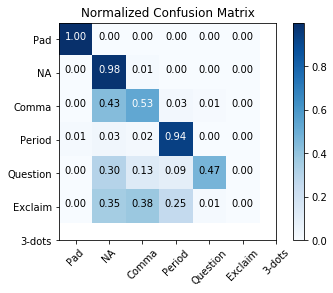

In [17]:
# Create confusion matrix and classification report
for_report = model.predict(test_x)
out_pred = [np.argmax(x, axis=1) for x in for_report]
out_pred = np.concatenate(out_pred, axis=0)

y_ = [np.argmax(x, axis=1) for x in test_y]
y_ = np.concatenate(y_, axis=0)

print('Test dataset distribution:', counts)
cm = confusion_matrix(y_true=y_, y_pred=out_pred)
print(cm)

cr = classification_report(y_true=y_, y_pred=out_pred)
print(cr)

plt.figure()
plot_confusion_matrix(cm, classes=class_names, normalize=True, title='Normalized Confusion Matrix')
plt.show()